In [38]:
# REGRESIÓN

In [39]:
## 1) Seleccion de Variables

In [40]:
'''
Debido a la correlación alta entre algunas variables de la matriz proporcionada, podemos seleccionar las siguientes:

Variables independientes :

A) seller_zip (Código postal del vendedor)
B) price (Precio del producto)
C) delivery_delay (Retraso en la entrega)

Variable dependiente:
 review_score (Puntuación de la reseña)
'''

'\nDebido a la correlación alta entre algunas variables de la matriz proporcionada, podemos seleccionar las siguientes:\n\nVariables independientes :\n\nA) seller_zip (Código postal del vendedor)\nB) price (Precio del producto)\nC) delivery_delay (Retraso en la entrega)\n\nVariable dependiente:\n review_score (Puntuación de la reseña)\n'

In [41]:
## 2) Importar Bibliotecas y Librerias

import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [42]:
## 3) Consulta Postgres
"""
SELECT 
    o.order_id,                             -- ID del pedido
    o.order_status,                         -- Estado del pedido
    o.order_purchase_timestamp,             -- Fecha de compra
    o.order_approved_at,                    -- Fecha de aprobación
    o.order_delivered_carrier_date,         -- Fecha de entrega al transportista
    o.order_delivered_customer_date,        -- Fecha de entrega al cliente
    o.order_estimated_delivery_date,        -- Fecha estimada de entrega
    c.customer_id,                          -- ID del cliente
    c.customer_zip_code_prefix,             -- Código postal del cliente
    s.seller_id,                            -- ID del vendedor
    s.seller_zip_code_prefix,               -- Código postal del vendedor
    oi.product_id,                          -- ID del producto
    oi.price,                               -- Precio del producto
    oi.freight_value,                       -- Valor del flete
    r.review_score,                         -- Puntuación de la reseña
    p.payment_type,                         -- Tipo de pago
    p.payment_installments,                 -- Número de cuotas
    p.payment_value,                        -- Valor del pago
    op.product_category_name,               -- Categoría del producto
    og.geolocation_lat,                     -- Latitud geográfica
    og.geolocation_lng                      -- Longitud geográfica
FROM
    olist_orders o
JOIN 
    olist_order_customers c ON o.customer_id = c.customer_id
JOIN 
    olist_order_items oi ON o.order_id = oi.order_id
JOIN 
    olist_products op ON oi.product_id = op.product_id 
JOIN 
    olist_sellers s ON oi.seller_id = s.seller_id
JOIN 
    olist_order_reviews r ON o.order_id = r.order_id
JOIN 
    olist_order_payments p ON o.order_id = p.order_id
JOIN 
    olist_geolocation og ON s.seller_zip_code_prefix = og.zip_code_prefix
WHERE
    c.customer_zip_code_prefix = og.zip_code_prefix AND
    o.order_delivered_customer_date IS NOT NULL
LIMIT 5;
"""


'\nSELECT \n    o.order_id,                             -- ID del pedido\n    o.order_status,                         -- Estado del pedido\n    o.order_purchase_timestamp,             -- Fecha de compra\n    o.order_approved_at,                    -- Fecha de aprobación\n    o.order_delivered_carrier_date,         -- Fecha de entrega al transportista\n    o.order_delivered_customer_date,        -- Fecha de entrega al cliente\n    o.order_estimated_delivery_date,        -- Fecha estimada de entrega\n    c.customer_id,                          -- ID del cliente\n    c.customer_zip_code_prefix,             -- Código postal del cliente\n    s.seller_id,                            -- ID del vendedor\n    s.seller_zip_code_prefix,               -- Código postal del vendedor\n    oi.product_id,                          -- ID del producto\n    oi.price,                               -- Precio del producto\n    oi.freight_value,                       -- Valor del flete\n    r.review_score,     

In [55]:
## Paso 4)  Conectar a Base de datos y Carga
'''
seller_zip: El código postal del vendedor.
price: El precio del producto.
delivery_delay: El retraso en la entrega expresado en un formato de duración (days hh:mm:ss).
review_score: La puntuación de la reseña.
'''

try:
    conn = psycopg2.connect(
        dbname="olist_ecommerce",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5432",
        options="-c client_encoding=UTF8"
    )

    # Crear un cursor para ejecutar la consulta
    cur = conn.cursor()

    # Ejecutar la consulta para obtener los datos de la vista
    cur.execute("SELECT seller_zip_code_prefix as seller_zip, price, (order_delivered_customer_date - order_estimated_delivery_date) as delivery_delay, review_score FROM olist_ecommerce;")
    
    # Convertir los resultados a un DataFrame de pandas
    df = pd.DataFrame(cur.fetchall(), columns=['seller_zip', 'price', 'delivery_delay', 'review_score'])
    
    # Mostrar algunas filas para verificar los datos
    print(df.head())

except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

finally:
    # Cerrar la conexión si fue abierta
    if conn:
        cur.close()
        conn.close()
        print("Conexión cerrada.")

   seller_zip  price     delivery_delay  review_score
0       14940   59.9 -28 days +17:53:43             3
1       14940   59.9 -28 days +17:53:43             3
2       14940   59.9 -28 days +17:53:43             3
3       14940   59.9 -28 days +17:53:43             3
4       14940   59.9 -28 days +17:53:43             3
Conexión cerrada.


In [56]:
#### Convertir 'delivery_delay' a días como número flotante
df['delivery_delay'] = df['delivery_delay'].dt.days

#### Verificar los cambios
print(df.head())


   seller_zip  price  delivery_delay  review_score
0       14940   59.9             -28             3
1       14940   59.9             -28             3
2       14940   59.9             -28             3
3       14940   59.9             -28             3
4       14940   59.9             -28             3


In [44]:
## Paso 5.  Usando la función train_test_split para dividir los datos en un 70% para entrenamiento y 30% para prueba:'''

In [57]:
# Dividir los datos en características (X) y variable dependiente (y)
X = df[['seller_zip', 'price', 'delivery_delay']]
y = df['review_score']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verificar las dimensiones de los conjuntos divididos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (4167, 3)
Tamaño del conjunto de prueba: (1786, 3)


In [46]:
# Paso 4. Modelo de regresión lineal y entrenamiento

In [58]:
## Verificar tipos de datos
print(X_train.dtypes)

### Si alguna columna tiene tipo 'object', convertir a numérico (ejemplo: con el código postal del vendedor)
X_train['seller_zip'] = pd.to_numeric(X_train['seller_zip'], errors='coerce')
X_test['seller_zip'] = pd.to_numeric(X_test['seller_zip'], errors='coerce')

### Verificar si existen valores nulos
print(X_train.isnull().sum())

### Opcional: Imputar valores nulos o eliminar filas/columnas con valores nulos
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


seller_zip          int64
price             float64
delivery_delay      int64
dtype: object
seller_zip        0
price             0
delivery_delay    0
dtype: int64


In [48]:
# Convertir 'delivery_delay' a días como número flotante
X_train['delivery_delay'] = X_train['delivery_delay'].dt.days
X_test['delivery_delay'] = X_test['delivery_delay'].dt.days

# Verificar nuevamente los tipos de datos
print(X_train.dtypes)

seller_zip          int64
price             float64
delivery_delay      int64
dtype: object


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Instanciar el modelo de regresión lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE) y el coeficiente de determinación (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Error Cuadrático Medio (MSE): 1.0592313909535767
Coeficiente de determinación (R²): 0.1846004312287436


In [60]:
''' 
Error Cuadrático Medio (MSE): 1.05921390953767, indica que en promedio el modelo está en un error cuadrático medio de 1.06 puntos en la review_score.
El coeficiente de Determinación (R²): 0.1846004312287436, indica qué proporción de la varianza en la variable dependiente (review_score) 
es explicada por las variables independientes (seller_zip, price, delivery_delay). Un valor de R² de 0.18 significa que el 18.46% de la variación 
en las puntuaciones de las reseñas es explicada por el modelo. 
Esto indica que el modelo no está capturando bien la relación entre las características y la variable objetivo.
'''

' \nError Cuadrático Medio (MSE): 1.05921390953767, indica que en promedio el modelo está en un error cuadrático medio de 1.06 puntos en la review_score.\nEl coeficiente de Determinación (R²): 0.1846004312287436, indica qué proporción de la varianza en la variable dependiente (review_score) \nes explicada por las variables independientes (seller_zip, price, delivery_delay). Un valor de R² de 0.18 significa que el 18.46% de la variación \nen las puntuaciones de las reseñas es explicada por el modelo. \nEsto indica que el modelo no está capturando bien la relación entre las características y la variable objetivo.\n'

In [61]:
## Paso 5. Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

### Obtener los coeficientes de la regresión
coef = model.coef_
intercept = model.intercept_

print("Coeficientes de regresión:", coef)
print("Intercepto:", intercept)


Coeficientes de regresión: [-5.07669123e-06  2.49602435e-03 -5.59793258e-02]
Intercepto: 3.602161411576974


In [62]:
'''
Los coeficientes sugieren que las tres variables independientes:ubicación del vendedor, precio, y retraso en la entrega. Tienen un impacto poco signifiativo
en las reseñas. La variable con el mayor impacto es el delivery_delay, lo que resalta la importancia de la entrega puntual en la satisfacción del cliente.
'''

'\nLos coeficientes sugieren que las tres variables independientes:ubicación del vendedor, precio, y retraso en la entrega. Tienen un impacto poco signifiativo\nen las reseñas. La variable con el mayor impacto es el delivery_delay, lo que resalta la importancia de la entrega puntual en la satisfacción del cliente.\n'

In [50]:
## Paso 6. Evaluacion del Modelo

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio (MSE): {mse}")

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de determinación (R²): {r2}")


Error Cuadrático Medio (MSE): 1.0565704339797233
Coeficiente de determinación (R²): 0.1741225150664465


In [ ]:
''' El MSE se mantenga constante sugiere que el modelo tiene un rendimiento predecible,no óptimo, en cuanto a la precisión de las predicciones. 
Sin embargo, debido al bajo R², las predicciones del modelo no son particularmente útiles para explicar la variabilidad en las calificaciones.
'''

In [51]:
# Calcular los residuos
residuos = y_test - y_pred

# Mostrar los primeros residuos
print(residuos.head())


4040   -1.055777
4248   -1.055777
1966    0.770830
4766    0.908241
1374    0.588686
Name: review_score, dtype: float64


In [ ]:
#### Es la diferencia entre el valor real y el proporcionado por el modelo.

c:\Users\jmelo\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


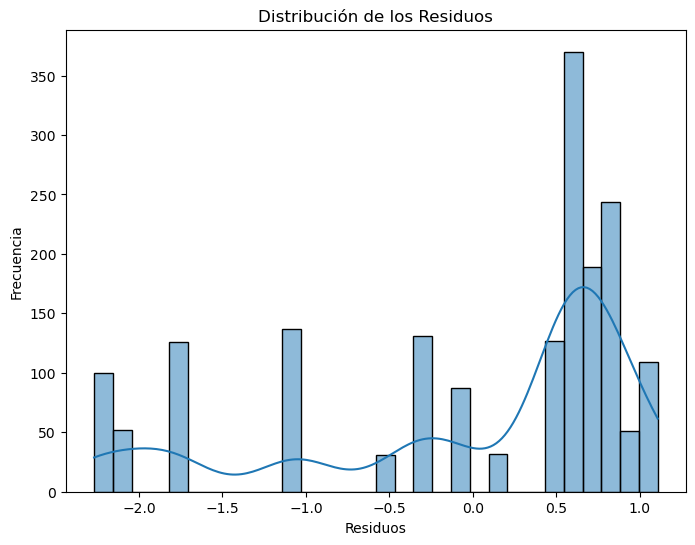

In [52]:
# Histograma de los residuos
plt.figure(figsize=(8, 6))
sns.histplot(residuos, kde=True, bins=30)
plt.title('Distribución de los Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
'''
Los residuos no están simétricamente distribuidos alrededor de cero. En lugar de una distribución normal, los residuos parecen estar concentrados 
en el rango positivo, especialmente alrededor de 0.5, indicando una asimetría hacia la derecha. Esto sugiere que el modelo tiende a subestimar 
las review_scores más frecuentemente que a sobreestimarlas.

El histograma muestra múltiples picos (o modos), lo cual puede indicar la presencia de varias subpoblaciones en los datos o que diferentes partes de los
 datos están siendo modeladas de manera diferente por el modelo de regresión lineal. Esto puede ser una señal de que un modelo lineal simple no está 
 capturando adecuadamente la estructura de los datos.
'''

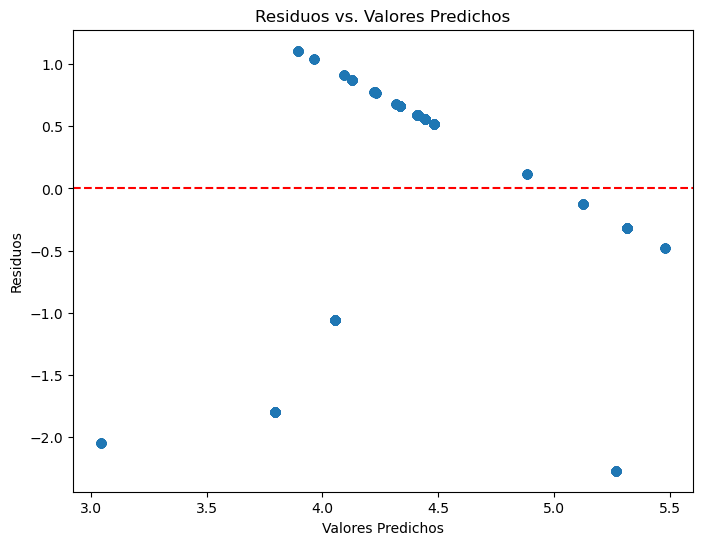

In [53]:
## Visualizar la distribución de los residuos

# Residuos vs. valores predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs. Valores Predichos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.show()

In [63]:
'''Esto indica que el modelo de regresión lineal no está capturando adecuadamente la relación entre las variables independientes y la variable dependiente. 
En este caso, parece que existe una relación no lineal entre los predictores y la review_score.
'''

'Esto indica que el modelo de regresión lineal no está capturando adecuadamente la relación entre las variables independientes y la variable dependiente. \nEn este caso, parece que existe una relación no lineal entre los predictores y la review_score.\n'

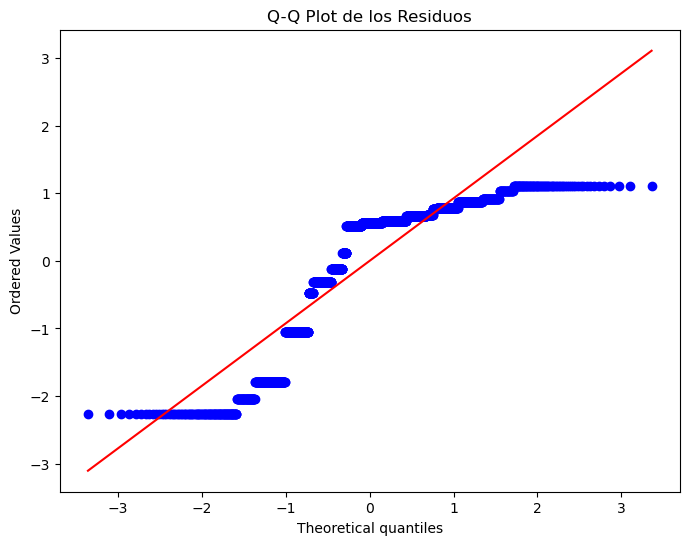

In [54]:
## Q-Q Plot (Gráfico Cuantil-Cuantil)

import scipy.stats as stats

# Q-Q plot para los residuos
plt.figure(figsize=(8, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot de los Residuos')
plt.show()


In [ ]:
'''
los residuos muestran desviaciones notables de la línea diagonal, especialmente en los extremos y alrededor de la mediana.
La curva en el Q-Q plot confirma que los residuos no siguen una distribución normal, lo que refuerza la idea de que el modelo de regresión lineal simple 
puede no ser el más adecuado para este conjunto de datos.
'''

In [64]:
### Paso 7. Modelo Random Forest

In [65]:
from sklearn.ensemble import RandomForestRegressor

# Instanciar el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)

# Ajustar el modelo a los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular el MSE y R² para el modelo de Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf}")
print(f"Random Forest - R²: {r2_rf}")


Random Forest - MSE: 0.0
Random Forest - R²: 1.0


In [69]:
''' Un MSE de 0.0 indica que el modelo predice los valores de review_score de manera perfecta, sin ningún error cuadrático medio. 
Este resultado es extremadamente inusual y sugiere que el modelo se ha ajustado de manera exacta a los datos.

Coeficiente de Determinación (R²): 1.0: El modelo explica el 100% de la variabilidad en los datos de review_score, teniendo un ajuste perfecto, 
donde las predicciones del modelo coinciden exactamente con los valores reales.

Los resultados indican un sobreajuste extremo. El modelo de Random Forest ha aprendido los detalles específicos del conjunto de datos de entrenamiento 
y prueba hasta el punto en que predice los valores exactamente.
'''

' Un MSE de 0.0 indica que el modelo predice los valores de review_score de manera perfecta, sin ningún error cuadrático medio. \nEste resultado es extremadamente inusual y sugiere que el modelo se ha ajustado de manera exacta a los datos.\n\nCoeficiente de Determinación (R²): 1.0: El modelo explica el 100% de la variabilidad en los datos de review_score, teniendo un ajuste perfecto, \ndonde las predicciones del modelo coinciden exactamente con los valores reales.\n\nLos resultados indican un sobreajuste extremo. El modelo de Random Forest ha aprendido los detalles específicos del conjunto de datos de entrenamiento \ny prueba hasta el punto en que predice los valores exactamente.\n'

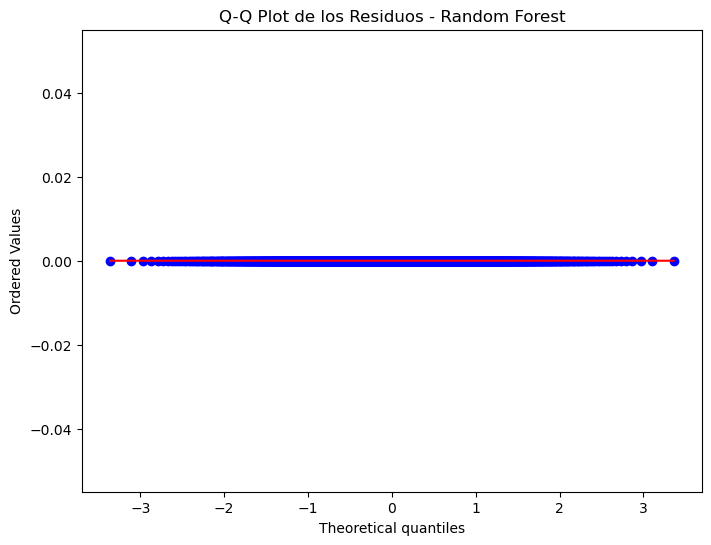

In [70]:
### Gráfico  Q-Q plot para los residuos

import matplotlib.pyplot as plt
import scipy.stats as stats

# Calcular los residuos
residuos_rf = y_test - y_pred_rf

# Q-Q plot para los residuos del modelo Random Forest
plt.figure(figsize=(8, 6))
stats.probplot(residuos_rf, dist="norm", plot=plt)
plt.title('Q-Q Plot de los Residuos - Random Forest')
plt.show()


In [71]:
''' 
El modelo de Random Forest ha sobreajustado los datos al punto de predecir los valores de review_score sin ningún error. 
Es un inconveneinte ya que muy seguramente no funcione bien con nuevos datos 
'''

' \nEl modelo de Random Forest ha sobreajustado los datos al punto de predecir los valores de review_score sin ningún error. \nEs un inconveneinte ya que muy seguramente no funcione bien con nuevos datos \n'

In [ ]:
## Paso 8: Modelo de Regrsion Logistica

In [ ]:
'''
Variable continua: distancia
Variable categórica/binaria: order_status
'''

In [ ]:
### Preparación de datos

In [82]:
import psycopg2
import pandas as pd

try:
    # Conectar a la base de datos PostgreSQL
    conn = psycopg2.connect(
        dbname="olist_ecommerce",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5432",
        options="-c client_encoding=UTF8"
    )

    # Crear un cursor para ejecutar la consulta
    cur = conn.cursor()

    # Ejecutar la consulta SQL ajustada
    cur.execute("""
        SELECT 
            o.order_id,
            o.order_status,
            o.order_purchase_timestamp,
            o.order_approved_at,
            o.order_delivered_carrier_date,
            o.order_delivered_customer_date,
            o.order_estimated_delivery_date,
            c.customer_id,
            c.customer_zip_code_prefix,
            s.seller_id,
            s.seller_zip_code_prefix,
            oi.product_id,
            oi.price,
            oi.freight_value,
            r.review_score,
            p.payment_type,
            p.payment_installments,
            p.payment_value,
            op.product_category_name,
            og.geolocation_lat,
            og.geolocation_lng
        FROM
            olist_orders o
        JOIN 
            olist_order_customers c ON o.customer_id = c.customer_id
        JOIN 
            olist_order_items oi ON o.order_id = oi.order_id
        JOIN 
            olist_products op ON oi.product_id = op.product_id 
        JOIN 
            olist_sellers s ON oi.seller_id = s.seller_id
        JOIN 
            olist_order_reviews r ON o.order_id = r.order_id
        JOIN 
            olist_order_payments p ON o.order_id = p.order_id
        JOIN 
            olist_geolocation og ON s.seller_zip_code_prefix = og.zip_code_prefix
        WHERE
            c.customer_zip_code_prefix = og.zip_code_prefix 
            AND o.order_delivered_customer_date IS NOT NULL;
    """)
    
    # Convertir los resultados a un DataFrame de pandas
    df = pd.DataFrame(cur.fetchall(), columns=[
        'order_id', 'order_status', 'order_purchase_timestamp', 
        'order_approved_at', 'order_delivered_carrier_date', 
        'order_delivered_customer_date', 'order_estimated_delivery_date', 
        'customer_id', 'customer_zip_code_prefix', 'seller_id', 
        'seller_zip_code_prefix', 'product_id', 'price', 
        'freight_value', 'review_score', 'payment_type', 
        'payment_installments', 'payment_value', 'product_category_name', 
        'geolocation_lat', 'geolocation_lng'
    ])
    
    # Mostrar algunas filas para verificar los datos
    print(df.head())

except Exception as e:
    print(f"Error al conectar a la base de datos: {e}")

finally:
    # Cerrar la conexión si fue abierta
    if conn:
        cur.close()
        conn.close()
        print("Conexión cerrada.")


                           order_id order_status order_purchase_timestamp  \
0  85b58bb30d219374cf9cfdebbc5fbb69    delivered      2017-02-10 09:37:46   
1  85b58bb30d219374cf9cfdebbc5fbb69    delivered      2017-02-10 09:37:46   
2  85b58bb30d219374cf9cfdebbc5fbb69    delivered      2017-02-10 09:37:46   
3  85b58bb30d219374cf9cfdebbc5fbb69    delivered      2017-02-10 09:37:46   
4  85b58bb30d219374cf9cfdebbc5fbb69    delivered      2017-02-10 09:37:46   

    order_approved_at order_delivered_carrier_date  \
0 2017-02-11 06:50:17          2017-02-17 09:54:05   
1 2017-02-11 06:50:17          2017-02-17 09:54:05   
2 2017-02-11 06:50:17          2017-02-17 09:54:05   
3 2017-02-11 06:50:17          2017-02-17 09:54:05   
4 2017-02-11 06:50:17          2017-02-17 09:54:05   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-02-17 17:53:43                    2017-03-17   
1           2017-02-17 17:53:43                    2017-03-17   
2           2017-

In [89]:
# Calcular la diferencia entre las fechas de entrega real y estimada
df['delivery_delay'] = df['order_delivered_customer_date'] - df['order_estimated_delivery_date']

# Convertir la diferencia en días
df['delivery_delay'] = df['delivery_delay'].dt.days

# Crear la variable binaria 'is_late': 1 si hubo retraso, 0 si no lo hubo
df['is_late'] = (df['delivery_delay'] > 0).astype(int)

# Seleccionar las características (variables predictoras) y la variable objetivo
X = df[['review_score', 'price']]
y = df['is_late']

# Calcular 'delivery_delay'
df['delivery_delay'] = df['order_delivered_customer_date'] - df['order_estimated_delivery_date']
df['delivery_delay'] = df['delivery_delay'].dt.days

# Crear la variable binaria 'is_late'
df['is_late'] = (df['delivery_delay'] > 0).astype(int)

# Seleccionar las características y la variable objetivo
X = df[['review_score', 'price']]
y = df['is_late']


In [90]:
### División del Conjunto de Datos

from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [91]:
### Entrenamiento del Modelo de Regresión Logística

from sklearn.linear_model import LogisticRegression

# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train, y_train)



LogisticRegression()

In [95]:
#### Entrenamiento del modelo con exito

In [92]:
### Evaluación del Modelo
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print('Matriz de confusión:')
print(conf_matrix)

# Generar un reporte de clasificación
class_report = classification_report(y_test, y_pred)
print('Reporte de clasificación:')
print(class_report)


Precisión del modelo: 1.00
Matriz de confusión:
[[1743    0]
 [   0   43]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1743
           1       1.00      1.00      1.00        43

    accuracy                           1.00      1786
   macro avg       1.00      1.00      1.00      1786
weighted avg       1.00      1.00      1.00      1786



In [ ]:
'''
Resultado:
El modelo predice correctamente el estado de retraso o no, en un 100% de los casos del conjunto de prueba.
-- 1743: Pedidos que no tuvieron retraso y fueron correctamente clasificados.
-- 43: Pedidos que tuvieron retraso y fueron correctamente clasificados.
-- 0 en las posiciones de errores: No hubo falsos positivos ni falsos negativos.

Los resultados indican que el modelo ha clasificado perfectamente todos los ejemplos en el conjunto de prueba, sin ningún error. 
Esto indica que hay sobreajuste.
'''

In [93]:
# Coeficientes
coef = model.coef_[0]
intercept = model.intercept_[0]

print(f'Coeficientes: {coef}')
print(f'Intercepto: {intercept}')


Coeficientes: [-6.17720809  0.03626434]
Intercepto: 4.614624755070565


In [94]:
# Modelo con un valor de regularización diferente
model = LogisticRegression(C=0.1, solver='liblinear')
model.fit(X_train, y_train)


LogisticRegression(C=0.1, solver='liblinear')

In [96]:
#### la probabilidad de que un pedido tenga un retraso disminuye, ya que una puntuación alta esta asociada con mejores servicios o productos.

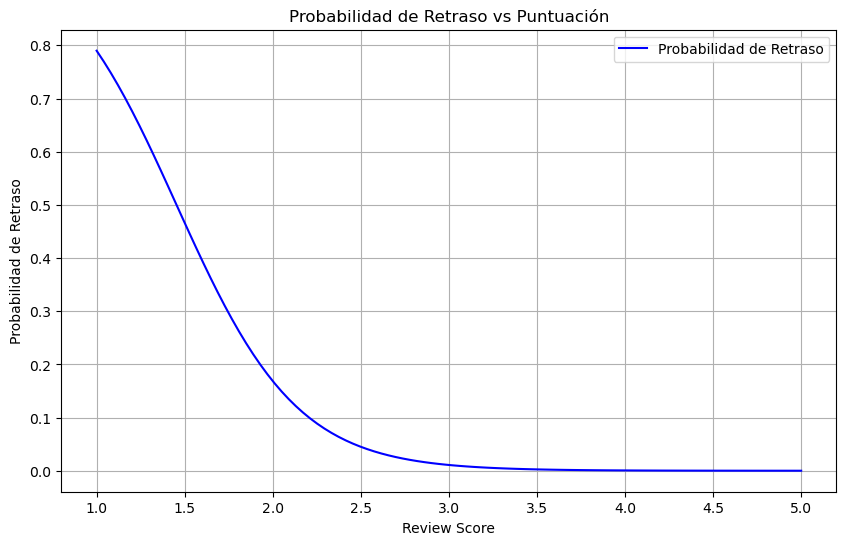

In [98]:
### Gráfico de Probabilidades Predichas vs Puntación


import numpy as np
import matplotlib.pyplot as plt

# Crear una serie de valores de review_score
review_scores = np.linspace(X['review_score'].min(), X['review_score'].max(), 100)

# Usar el precio medio para el gráfico
mean_price = X['price'].mean()

# Crear un DataFrame con los valores de review_score y el precio fijo
X_plot = pd.DataFrame({'review_score': review_scores, 'price': mean_price})

# Calcular las probabilidades predichas por el modelo
predicted_probs = model.predict_proba(X_plot)[:, 1]  # Probabilidad de que is_late sea 1

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(review_scores, predicted_probs, color='blue', label='Probabilidad de Retraso')
plt.xlabel('Review Score')
plt.ylabel('Probabilidad de Retraso')
plt.title('Probabilidad de Retraso vs Puntuación')
plt.legend()
plt.grid(True)
plt.show()


In [101]:
'''
Presenta una tendencia inversamente proporcional: A medida que la puntuación de la reseña aumenta, la probabilidad de retraso disminuye significativamente.
'''

'\nPresenta una tendencia inversamente proporcional: A medida que la puntuación de la reseña aumenta, la probabilidad de retraso disminuye significativamente.\n'

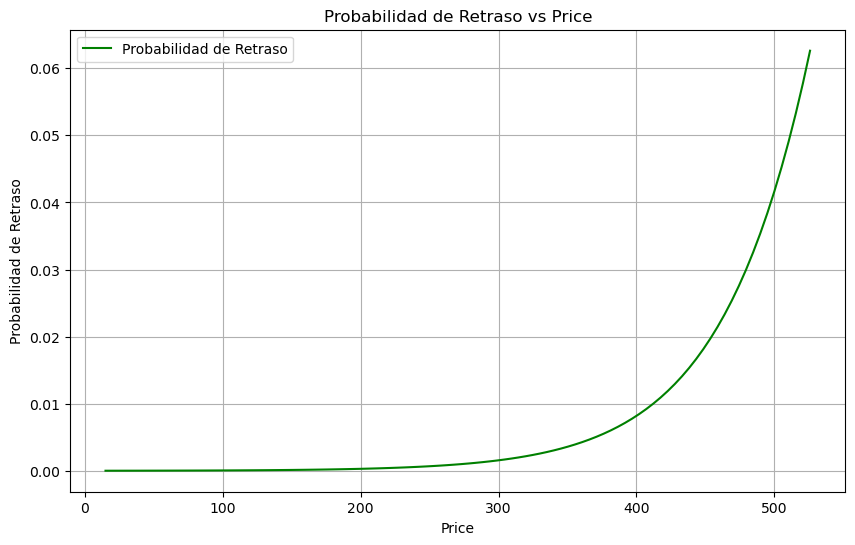

In [99]:
## Gráfico de Probabilidades Retraso vs Precio
# Crear una serie de valores de price
prices = np.linspace(X['price'].min(), X['price'].max(), 100)

# Usar el review_score medio para el gráfico
mean_review_score = X['review_score'].mean()

# Crear un DataFrame con los valores de price y el review_score fijo
X_plot_price = pd.DataFrame({'review_score': mean_review_score, 'price': prices})

# Calcular las probabilidades predichas por el modelo
predicted_probs_price = model.predict_proba(X_plot_price)[:, 1]  # Probabilidad de que is_late sea 1

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(prices, predicted_probs_price, color='green', label='Probabilidad de Retraso')
plt.xlabel('Price')
plt.ylabel('Probabilidad de Retraso')
plt.title('Probabilidad de Retraso vs Price')
plt.legend()
plt.grid(True)
plt.show()


In [100]:
'''
La curva es una función creciente, lo que significa que a medida que el precio del producto aumenta, la probabilidad de que el pedido se retrase 
también aumenta, aunque de manera no lineal.
'''

'\nLa curva es una función creciente, lo que significa que a medida que el precio del producto aumenta, la probabilidad de que el pedido se retrase \ntambién aumenta, aunque de manera no lineal.\n'